In [1]:
import dataclasses
import functools
import itertools

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import KetSugar as ks
import MaxLik as ml

samplings = np.load('probes_samplings.npz')
SAMPLING_KEY = 'n30'
cal_sampl = samplings[SAMPLING_KEY]
test_sampl = samplings['n108']

cal_states = np.array([ks.BlochKet(theta, phi) for theta, phi in cal_sampl])
test_states = np.array([ks.BlochKet(theta, phi) for theta, phi in test_sampl])




MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [3]:
def spherical_to_cartesian(theta, phi):
    """
    Convert spherical coordinates (colatitude theta, longitude phi)
    to 3D Cartesian coordinates (X, Y, Z).

    Parameters:
        theta (np.ndarray): 1D array of colatitude angles in radians.
        phi (np.ndarray): 1D array of longitude angles in radians.

    Returns:
        np.ndarray: Array of shape (N, 3) with rows [X, Y, Z].
    """
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.stack([x, y, z], axis=-1)

def rotation_matrix(axis, angle):
    """
    Compute the 3x3 rotation matrix for rotating around a given axis by a given angle.

    Parameters:
        axis (np.ndarray): 3-element array-like, the rotation axis (will be normalized).
        angle (float): Rotation angle in radians.

    Returns:
        np.ndarray: 3x3 rotation matrix.
    """
    axis = np.asarray(axis, dtype=float)
    axis = axis / np.linalg.norm(axis)
    x, y, z = axis
    c = np.cos(angle)
    s = np.sin(angle)
    C = 1 - c

    R = np.array([
        [c + x*x*C,     x*y*C - z*s, x*z*C + y*s],
        [y*x*C + z*s,   c + y*y*C,   y*z*C - x*s],
        [z*x*C - y*s,   z*y*C + x*s, c + z*z*C]
    ])
    return R



In [24]:
import HammerProj as hp

b1 = spherical_to_cartesian(test_sampl[:,0], test_sampl[:,1])
vrot = spherical_to_cartesian(np.array([0.1]), np.array([0.2]))[0]
b2 = (rotation_matrix(vrot, np.pi/16) @ b1.T).T




### Random notes:

**relation between Bloch vector deviation and fidelity:**

Bloch deviation is
$$
\vec{u} \vec{b} = \cos \delta
$$

and it corresponds to fidelity
$$
|\langle u|v \rangle|^2 = \cos^2(\delta/2)
$$

With $2\cos^2(\delta/2) -1  = \cos \delta$ we have
$$
|\langle u|v \rangle|^2 = \cos^2(\delta/2) = (1 + \cos\delta)/2 = (1 + \vec{u}\vec{v})/2
$$

**fidelity reduction by purity:**

Let $\rho = \lambda |\psi\rangle\langle\psi| + (1-\lambda) |\psi_\bot\rangle\langle\psi_\bot|$.
$\lambda$ is related to purity via

$$
P = 2\lambda^2 - 2\lambda + 1
$$
which is quadratic equation

$$
\lambda^2 - \lambda + (1-P)/2 = 0
$$

It has solutions
$$
\lambda = \frac{1}{2} \left(  1 \pm \sqrt{2P-1}  \right)
$$
We will assign $\lambda$ to the dominant term, and therefore take only plus sign in the formula.

Fidelity of mixed $\rho$ with some pure $|\pi\rangle$ is
$$
F = \lambda |\langle \pi | \psi \rangle|^2 + (1-\lambda) |\langle \pi | \psi_\bot \rangle|^2
$$

Let us substitute $|\langle \pi | \psi \rangle|^2 = f$ and $|\langle \pi | \psi_\bot \rangle|^2 = 1 - f$, then
$$
F = \lambda f + (1-\lambda)(1-f)


In [45]:
def procrute_rot(vecs_ref: np.ndarray, vecs_test: np.ndarray) -> np.ndarray:
    """
    Compute the optimal rotation matrix that aligns vecs_test to vecs_ref using the Kabsch algorithm.

    Parameters:
        vecs_ref (np.ndarray): Reference vectors of shape (N, 3).
        vecs_test (np.ndarray): Test vectors to be rotated, of shape (N, 3).

    Returns:
        np.ndarray: The optimal 3x3 rotation matrix.
    """
    n1, dim1 = vecs_ref.shape
    n2, dim2 = vecs_test.shape
    assert n1 == n2, "Input arrays must have the same number of vectors"
    assert dim1 == 3 and dim2 == 3, "Input vectors must be 3-dimensional"
    # Covariance matrix
    H = vecs_ref.T @ vecs_test
    U, sigma, Vh = np.linalg.svd(H)
    d = np.linalg.det(U @ Vh)
    rot = U @ np.diag([1, 1, d]) @ Vh
    return rot

def ket_to_bloch_v(ket):
    ket = ket.ravel()
    theta = 2*np.angle(np.abs(ket[0]) + 1j*np.abs(ket[1]))
    phi = np.angle(ket[1]) - np.angle(ket[0])
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array((x,y,z))

def meas_relative_fidelity_all(rhos_ref, rhos_test):
    #find dominant eigenvectors and turn them to Bloch
    bloch_ref = np.zeros((rhos_ref.shape[0],3))
    bloch_test = np.zeros((rhos_test.shape[0],3))
    eigval_test = np.zeros((rhos_test.shape[0],1))
    for i, r in enumerate(rhos_test):
        eigvalues, eigvectors = np.linalg.eigh(r)
        bloch_test[i] = ket_to_bloch_v(eigvectors[:,-1])
        eigval_test[i] = eigvalues[-1]
    for i, r in enumerate(rhos_ref):
        eigvalues, eigvectors = np.linalg.eigh(r)
        bloch_ref[i] = ket_to_bloch_v(eigvectors[:,-1])
    #use procrute analysis to find optimal rotation
    rot = procrute_rot(bloch_ref, bloch_test)
    bloch_mapped_test = (rot @ bloch_test.T).T

    #calculate deviations of Bloch vector and turn them into fidelities
    #scalar product of reference and mapped test
    cos_deltas = np.clip(np.sum(bloch_ref * bloch_mapped_test, axis=1),-1,1)
    
    #fidelity of dominant eigenvector
    domfid = (cos_deltas + 1)*0.5
    #overall fidelity
    fid = eigval_test*domfid + (1-eigval_test)*(1-domfid)
    return domfid, fid

def meas_relative_fidelity_worst(rhos_ref, rhos_test):
    domfid, fid = meas_relative_fidelity_all(rhos_ref, rhos_test)
    return np.min(domfid), np.min(fid)

In [49]:
b1 = np.array([ks.ketbra(k,k) for k in test_states])
urot = np.array([1,0,0,np.exp(1j*np.pi/8)]).reshape((2,2))
b2 = np.array([0.9*ks.ketbra(urot @ k, urot @ k) + 0.1*np.eye(2)/2 for k in test_states])

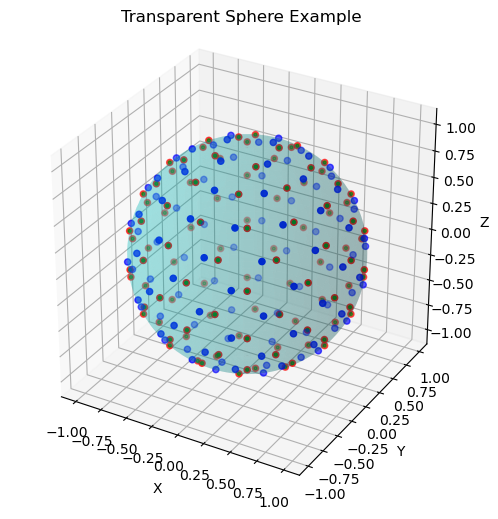

In [38]:
def plot_transparent_sphere(ax, radius=1, alpha=0.2, color='b'):
    """
    Plot a semitransparent sphere centered at the origin in 3D.

    Parameters:
        ax (matplotlib.axes._subplots.Axes3DSubplot): The 3D axis to plot on.
        radius (float): Radius of the sphere.
        alpha (float): Transparency of the sphere surface.
        color (str): Color of the sphere.
    """
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0, zorder=0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
plot_transparent_sphere(ax, radius=1, alpha=0.2, color='c')
ax.scatter3D(A[:,0], A[:,1], A[:,2], marker='o', c='red')
ax.scatter3D(B[:,0], B[:,1], B[:,2], marker='o', c='blue')
ax.scatter3D(C[:,0], C[:,1], C[:,2], marker='.', c='green')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect((1,1,1))
ax.set_title('Transparent Sphere Example')
plt.show()